In [483]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

In [484]:
data = yf.download("ETH-USD", start="2021-03-11", end="2022-03-11")

[*********************100%***********************]  1 of 1 completed


In [485]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-11,1798.033936,1843.818848,1734.617065,1826.194946,1826.194946,24013132909
2021-03-12,1826.546753,1839.497314,1728.980957,1772.102417,1772.102417,22435821312
2021-03-13,1772.166382,1937.645508,1733.639893,1924.685425,1924.685425,25014689475
2021-03-14,1923.863770,1930.779785,1845.119995,1854.564331,1854.564331,19344589211
2021-03-15,1854.086670,1889.196655,1749.606323,1791.702271,1791.702271,26244738810


In [486]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-07,2555.297607,2639.943115,2455.593750,2497.771240,2497.771240,14594098731
2022-03-08,2497.721436,2618.166016,2489.755127,2576.747559,2576.747559,13922922903
2022-03-09,2577.165283,2761.796387,2573.655273,2729.783447,2729.783447,14173665398
2022-03-10,2729.116455,2729.116455,2566.193115,2608.048584,2608.048584,13292477213
2022-03-11,2608.271240,2664.558594,2534.688232,2559.562988,2559.562988,12382419582


In [487]:
data['Adj Close'].head()

Date
2021-03-11    1826.194946
2021-03-12    1772.102417
2021-03-13    1924.685425
2021-03-14    1854.564331
2021-03-15    1791.702271
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

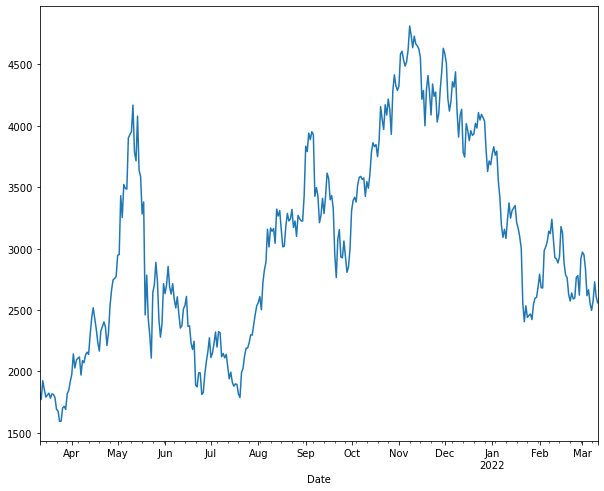

In [600]:
data['Adj Close'].plot(figsize=(10, 8), subplots=True)

In [492]:
SP = data['Adj Close'][-1]
print('The Spot Price is', round(SP,2))

The Spot Price is 2559.56


In [543]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [546]:
vol = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 99.06 %


In [599]:
vol = np.sqrt(365) * log_return[180:-1].std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 82.36 %


In [598]:
vol = np.sqrt(365) * log_return[90:-1].std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 85.1 %


# CRR BINOMIAL TREE

In [547]:
import os

In [548]:
S0 = 2559.56              # spot stock price
K = 3052.50               # strike  \ State the date u pick the excise price
T = 1/12                 # maturity 
r = 0.0114                 # US Treasure 1-yaear rate  
sig = 0.99               # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"   

In [549]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u  

In [550]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [551]:
S

array([[2559.56      , 3018.72745093, 3560.26638289, 4198.95367276],
       [   0.        , 2170.23480924, 2559.56      , 3018.72745093],
       [   0.        ,    0.        , 1840.12843114, 2170.23480924],
       [   0.        ,    0.        ,    0.        , 1560.23331148]])

In [552]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4597987386977997

In [553]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[   0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,   33.77254907],
       [   0.        ,    0.        ,    0.        ,  882.26519076],
       [   0.        ,    0.        ,    0.        , 1492.26668852]])

In [554]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 601.38048678,  274.06381985,   18.23819726,    0.        ],
       [   0.        ,  880.33255283,  491.97352803,   33.77254907],
       [   0.        ,    0.        , 1211.40509689,  882.26519076],
       [   0.        ,    0.        ,    0.        , 1492.26668852]])

In [555]:
print('European ' + payoff, str( V[0,0]))

European put 601.3804867841649


In [556]:
print('American ' + payoff, str( V[0,0]))

American put 601.3804867841649


# MONTE CARLO SIMULATION

In [557]:
def mcs_simulation_np(p):
    M = p          # M = time step
    I = p          # I = simulation
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [558]:
T = 1/12
r = 0.0114
sigma = 0.99
S0 = 2559.56
K = 3052.50

In [559]:
S = mcs_simulation_np(10000)

In [560]:
S = np.transpose(S)
S

array([[2559.56      , 2555.48506472, 2563.37228723, ..., 1656.05876021,
        1659.49541777, 1660.76893238],
       [2559.56      , 2554.12239902, 2568.55375102, ..., 2627.80826815,
        2632.16998138, 2627.41004138],
       [2559.56      , 2552.26107037, 2546.90014944, ..., 2791.6254347 ,
        2787.03710106, 2784.75728625],
       ...,
       [2559.56      , 2566.9655636 , 2570.76593616, ..., 1630.73708063,
        1640.28999168, 1640.41663541],
       [2559.56      , 2567.47429847, 2564.02688234, ..., 1820.02898582,
        1807.81216939, 1815.47463119],
       [2559.56      , 2550.41717548, 2551.27537506, ..., 1480.69502873,
        1484.80602449, 1486.70337481]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

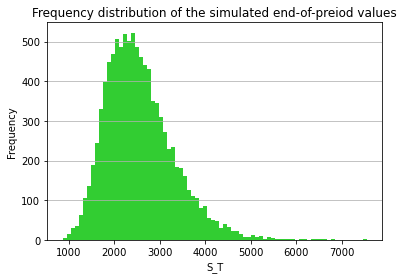

In [561]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#32cd32',alpha=1, rwidth=2.5)

plt.grid(axis='y', alpha=0.95)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [562]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 628.2914317269649


In [563]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 131.02764673579136


# BLACK SCHOLES MODEL

In [564]:
def euro_option_bsm(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [565]:
euro_option_bsm(2559.56, 3052.50, 1/12, 0.0114, 0.99, 'call')

131.13507606946712

In [566]:
euro_option_bsm(2559.56, 3052.50, 1/12, 0.0114, 0.99, 'put')

621.1765780740059

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

# Surface of Delta

In [567]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(- q * T) * si.norm.cdf(- d1, 0.0, 1.0)
    
    return delta

In [568]:
S = np.linspace(1590, 5000, 500)
T = np.linspace(0.5, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 3052.52, T[i], 0.0114, 0.00, 0.99, 'put')

C:\Users\S.K\AppData\Local\Temp/ipykernel_30996/293324328.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


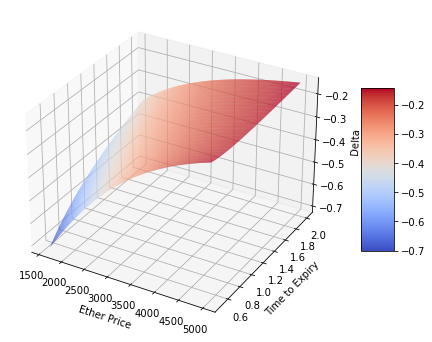

In [569]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ether Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [570]:
delta(2559.56, 3052.50, 1/52, 0.0114, 0.00, 0.99, 'call')

0.11263234202534833

In [571]:
delta(2559.56, 3052.50, 1/52, 0.0114, 0.00, 0.99, 'put')

-0.8873676579746517

# Surface of Gamma

In [572]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [573]:
S = np.linspace(1590, 5000, 500)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 3052.52, T[i], 0.0114, 0.00, 0.99, 'put')

C:\Users\S.K\AppData\Local\Temp/ipykernel_30996/2062502602.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


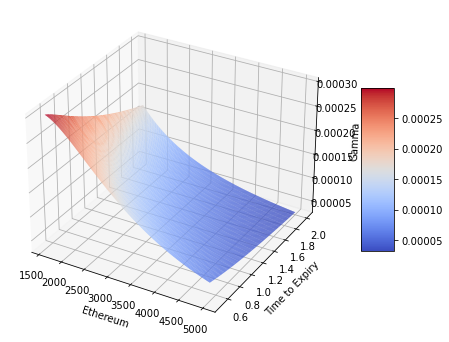

In [574]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [575]:
gamma(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'call')

0.0004878735366359609

In [601]:
gamma(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'put')

0.0004878735366359609

# Surface of Speed

In [577]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [578]:
S = np.linspace(1590, 5000, 500)
T = np.linspace(0.5, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 3052.52, T[i], 0.0114, 0.00, 0.99, 'put')

C:\Users\S.K\AppData\Local\Temp/ipykernel_30996/546263582.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


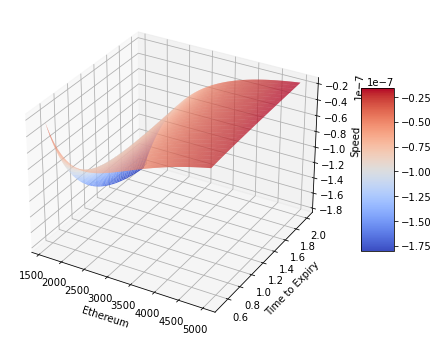

In [579]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [580]:
speed(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'call')

3.551246648178472e-08

In [581]:
speed(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'put')

3.551246648178472e-08

# Surface of Theta

In [582]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [583]:
S = np.linspace(1590, 5000, 500)
T = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 3052.52, T[i], 0.0114, 0.00, 0.99, 'call')

C:\Users\S.K\AppData\Local\Temp/ipykernel_30996/1399786643.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


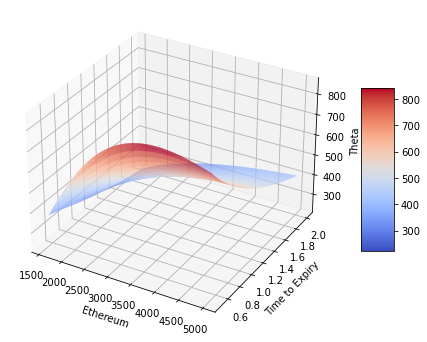

In [584]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [585]:
theta(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'call')

1575.6184326305636

In [586]:
theta(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'put')

1594.748496494236

# Surface of rho

In [587]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [588]:
S = np.linspace(1590, 5000, 500)
T = np.linspace(0.5, 2, 51)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 3052, T[i], 0.0114, 0.00, 0.99, 'put')

C:\Users\S.K\AppData\Local\Temp/ipykernel_30996/1522276522.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


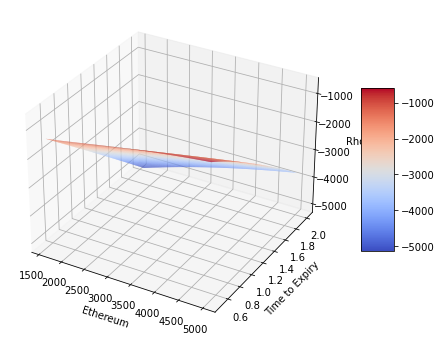

In [589]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [590]:
rho(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'call')

57.1469051870591

In [591]:
rho(2559.56, 3052.50, 1/12, 0.0114, 0.00, 0.99, 'put')

-196.98655331331915

# Surface of vega

In [592]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [593]:
S = np.linspace(1590, 5000, 500)
T = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 3052, T[i], 0.0114, 0.00, 0.99, 'call')

C:\Users\S.K\AppData\Local\Temp/ipykernel_30996/2481859496.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


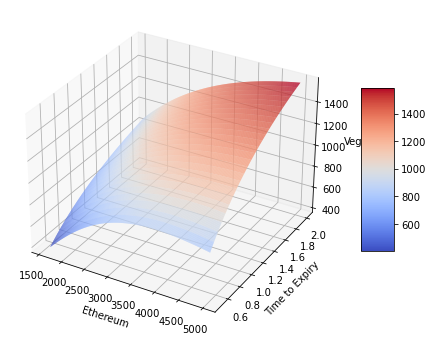

In [594]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [595]:
vega(2559.56, 3052.50, 1/52, 0.0114, 0.00, 0.99, 'call')

67.88217478862363

In [596]:
vega(2559.56, 3052.50, 1/52, 0.0114, 0.00, 0.99, 'put')

67.88217478862363